# Categorical Variables
A categorial varuable takes only a limited number of values.<br>
Consider a survey that asks what brand of car they owned, the responses would fall into categories like Honda, Toyota, Ford etc. In this case the data is categorical.<br>
<br>
We can get an error if we try to plug these variables into most machine learning models in Python withoud preprocessing them first.<br>
There are 3 approaches that we can use to prepare our catogorical data.<br>
<br>
1) Drop Categorical Variables<br> 
The easiest way to deal with categorical variables is to simple remove them from the dataset. This approcah will only work well if the columns did not contain useful information.<br>
2) Label Encoding<br>
Label encoding assigns each unique value to a different integer.
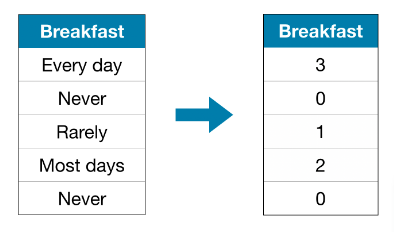
This assumption makes sense in this example as there is as indisputable ranking to the categories. Not all categorical variables have a clear ordering in the values, but we refer to those that do as ordinal variables. For tree-based models (decision trees and random forests), we can expect the label encoding to work well with the ordinal variables.<br>
3) One-Hot Encoding<br>
One -Hot encoding creates new columns indicating the presence of apsence of each possible value in the original data.
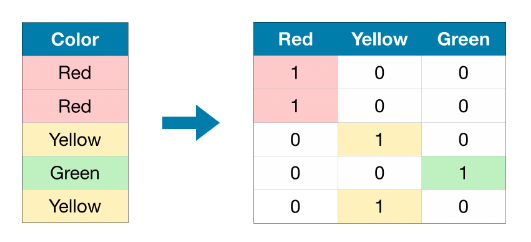
It does not assume ordering of the categories like the Label Encoding. Thus we can expect this approac to work well if there is no clear ordering in the categorical data. Example "Red" is neither more nor less than "Yellow". We refer to categorical variables without as intrinsic ranking as nominal variables.<br>
One-hot encoding generally does not perfoem well if the categorical variable takes on a large number of values, i.e. we generally won't use it for variables taking more than 15 different values.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('Datasets/melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [2]:
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,555.0,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,265.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,673.0,-37.76230,144.8272,4217.0


We obtain the list of all categorical variables in the training data.<br>
We do this by checking the data typr or dtype of each column. The object dtype indicates a column has a text. For this dataset columns with text indicate categorical variables.

In [3]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)
print('Categorical variables: ')
print(object_cols)

Categorical variables: 
['Type', 'Method', 'Regionname']


We define the function score_dataset() to compare the 3 different approaches to dealing with categorical variables. This function reports the mean absolute error (MAE) from a random forest model. In general we want MAE as low as possible.

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

## Approach 1: Drop categorical values
We drop the object columns with the select_dtypes() method

In [5]:
drop_X_train = X_train.select_dtypes(exclude = ['object'])
drop_X_valid = X_valid.select_dtypes(exclude = ['object'])

print("MAE from Approach 1 , Drop Categorical variables is : ")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 , Drop Categorical variables is : 
175703.48185157913


## Approach 2: Label Encoding
Scikit-learn has a LabelEncoder class that can be used to get label encodings. We loop over the categorical variables and apply the label encoder separately to each column.

In [7]:
from sklearn.preprocessing import LabelEncoder

# Make a copy to avoid changing the original data
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

#Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])
    
print("MAE from Approach 2, Label Encoding: ")
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2, Label Encoding: 
165936.40548390493


In the code cell above, for each column we randomly assign each unique value to a different integer. This is a common approach that is simpler than providing custome labels. However we can expect an additional boost in performance it we provide better informed labels for all ordinal variables.

## Approach 3: One-Hot Encoding
We use the One-Hot Encoding class from the scikit-learn to get one-hot encodings. There are a number of parameters that can be used to customise its behavior.<br>
1) We set handle_unknown = 'ignore' to avoid the errors when validation data contains classes that aren't representedin the training data<br>
2) Setting sparse = False ensures that the encoded columns are returned as a numpy array instead of a sparse matrix<br>
<br>
To use the encoder we supply only the categorical columns that we want to be one-hot encoder. For instance to encode the training data, we supply X_train[object_cols]. It will contain all the categorical data in the training set.

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Apple one-hot encoder to each column with categorical data
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train[object_cols]))
ohe_cols_valid = pd.DataFrame(ohe.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
ohe_cols_train.index = X_train.index
ohe_cols_valid.index = X_valid.index

# Remove the categorical columns, replace with one-hot encoding
num_X_train = X_train.drop(object_cols, axis = 1)
num_X_valid = X_valid.drop(object_cols, axis = 1)

# Add one-hot encoded columns to numerical features
ohe_X_train = pd.concat([num_X_train, ohe_cols_train], axis = 1)
ohe_X_valid = pd.concat([num_X_valid, ohe_cols_valid], axis = 1)

print("MAE from Approach 3 One hot Encoding is : ")
print(score_dataset(ohe_X_train, ohe_X_valid, y_train, y_valid))

MAE from Approach 3 One hot Encoding is : 
166089.4893009678
